In [25]:
import pandas as pd
# 读取process_data/20230516.csv
df = pd.read_csv('process_data/20230516_labeled.csv', encoding='utf-8')
# 构造Spread列
df['Spread'] = df['Ask1Price'] - df['Bid1Price']
# 构造Depth Ratio列
df['Depth Ratio'] = df['Bid1Volume'] / df['Ask1Volume']
# 构造OBl列
df['OBl'] = (df['Bid1Volume'] - df['Ask1Volume']) / (df['Bid1Volume'] + df['Ask1Volume'])
# 删除Traded列
df.drop('Traded', axis=1, inplace=True)
df.drop('FutureAvgPrice', axis=1, inplace=True)
test_data = df
test_data

,Time,LastPrice,Volume,Bid1Price,Bid1Volume,Ask1Price,Ask1Volume,Spread,Depth Ratio,OBl
0,2023-05-16 09:30:00,6084.0,13,6082.0,1,6083.6,1,1.6,1.000000,0.000000
1,2023-05-16 09:30:00,6083.2,18,6075.2,1,6081.6,1,6.4,1.000000,0.000000
2,2023-05-16 09:30:01,6081.6,22,6079.4,1,6081.4,2,2.0,0.500000,-0.333333
3,2023-05-16 09:30:01,6081.6,28,6083.6,1,6084.0,2,0.4,0.500000,-0.333333
4,2023-05-16 09:30:02,6083.6,33,6080.8,1,6083.6,3,2.8,0.333333,-0.500000
...,...,...,...,...,...,...,...,...,...,...
10005,2023-05-16 14:02:02,6041.4,4981,6041.4,2,6042.0,1,0.6,2.000000,0.333333
10006,2023-05-16 14:02:05,6041.4,4983,6041.0,1,6042.0,1,1.0,1.000000,0.000000
10007,2023-05-16 14:02:05,6041.4,4983,6041.0,1,6041.4,1,0.4,1.000000,0.000000
10008,2023-05-16 14:02:06,6041.0,4984,6040.6,1,6041.0,1,0.4,1.000000,0.000000


In [6]:
# # 将test_data储存为test_data_lstm.csv
# test_data.to_csv('process_data/data_test_lstm.csv', index=False)

In [7]:
import pandas as pd
# 读取process_data/20230516.csv
df = pd.read_csv('process_data/merged_data_0508_0515.csv', encoding='utf-8')
# 构造Spread列
df['Spread'] = df['Ask1Price'] - df['Bid1Price']
# 构造Depth Ratio列
df['Depth Ratio'] = df['Bid1Volume'] / df['Ask1Volume']
# 构造OBl列
df['OBl'] = (df['Bid1Volume'] - df['Ask1Volume']) / (df['Bid1Volume'] + df['Ask1Volume'])
# 删除Traded列
df.drop('Traded', axis=1, inplace=True)
df.drop('FutureAvgPrice', axis=1, inplace=True)
train_data = df

train_data

,Time,LastPrice,Volume,Bid1Price,Bid1Volume,Ask1Price,Ask1Volume,Spread,Depth Ratio,OBl
0,5/8/2023 9:30,6117.0,7,6113.0,1,6116.0,1,3.0,1.0,0.000000
1,5/8/2023 9:30,6116.0,9,6115.6,2,6118.8,1,3.2,2.0,0.333333
2,5/8/2023 9:30,6114.2,13,6113.8,1,6118.2,2,4.4,0.5,-0.333333
3,5/8/2023 9:30,6114.2,15,6115.4,1,6117.6,2,2.2,0.5,-0.333333
4,5/8/2023 9:30,6117.4,25,6116.0,1,6117.4,2,1.4,0.5,-0.333333
...,...,...,...,...,...,...,...,...,...,...
87198,5/15/2023 14:59,6083.4,9403,6083.4,1,6084.2,1,0.8,1.0,0.000000
87199,5/15/2023 15:00,6083.4,9403,6083.4,1,6084.2,1,0.8,1.0,0.000000
87200,5/15/2023 15:33,6083.4,9403,6083.4,1,6084.2,1,0.8,1.0,0.000000
87201,5/15/2023 15:37,6083.4,9403,6083.4,1,6084.2,1,0.8,1.0,0.000000


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 假设您的数据已经存储在train_data和test_data中，包含了Time, LastPrice, Volume, Bid1Price, Bid1Volume, Ask1Price, Ask1Volume, Spread, Depth Ratio, OBl等列

# 提取需要预测的列作为目标变量
target_cols = ['LastPrice']
train_data = train_data[target_cols].values
test_data = test_data[target_cols].values

# 归一化处理
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# 构建训练集和测试集
sequence_length = 300  # 可根据实际情况调整

# 定义函数，将时间序列数据转换为适用于LSTM的输入数据格式
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length - 10):  # 预测未来十秒，因此减去10
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+10])  # 预测未来十秒的数据
    return np.array(x), np.array(y)

# 创建训练集和测试集的序列数据
x_train, y_train = create_sequences(scaled_train_data, sequence_length)
x_test, y_test = create_sequences(scaled_test_data, sequence_length)

# 构建LSTM模型
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, len(target_cols))))
model.add(Dense(10))  # 输出未来十秒的数据，因此输出大小为10
model.compile(loss='mse', optimizer='adam')

# 训练模型
model.fit(x_train, y_train, epochs=1, batch_size=32)

# 在测试集上进行预测
predictions = model.predict(x_test)

# 将预测结果逆归一化
predictions = scaler.inverse_transform(predictions)

# 打印预测结果
predicted_data = pd.DataFrame(predictions, columns=[f'LastPrice_{i+1}' for i in range(10)])  # 创建包含未来十秒的预测数据的DataFrame
print(predicted_data)

304/304 [==============================] - 8s 25ms/step
      LastPrice_1  LastPrice_2  LastPrice_3  LastPrice_4  LastPrice_5  \
0     6076.328125  6076.307617  6076.507324  6076.537598  6076.647949   
1     6076.361328  6076.335938  6076.533691  6076.562988  6076.675781   
2     6076.390137  6076.360840  6076.556641  6076.584473  6076.700195   
3     6076.428711  6076.412109  6076.612793  6076.634766  6076.755371   
4     6076.473633  6076.460449  6076.664551  6076.688477  6076.805664   
...           ...          ...          ...          ...          ...   
9695  6041.567383  6041.782715  6041.785645  6041.837402  6041.848633   
9696  6041.604004  6041.821777  6041.827148  6041.882324  6041.888184   
9697  6041.623535  6041.818359  6041.813477  6041.876465  6041.876465   
9698  6041.622559  6041.797852  6041.780762  6041.843750  6041.847656   
9699  6041.592773  6041.742676  6041.710938  6041.770996  6041.781738   

      LastPrice_6  LastPrice_7  LastPrice_8  LastPrice_9  LastPrice

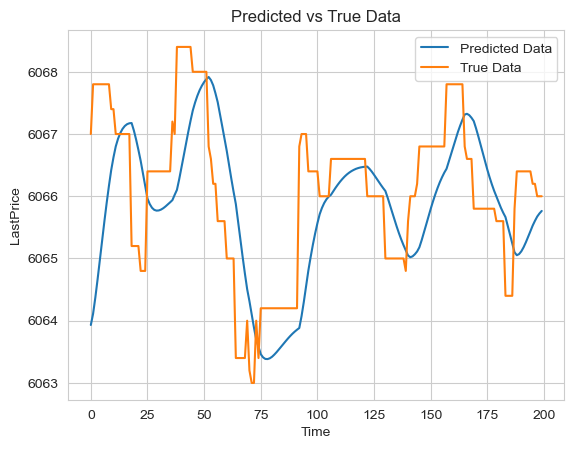

In [23]:
import matplotlib.pyplot as plt

# 假设你已经有了预测数据predicted_data
average_predictions = np.mean(predictions, axis=1)

# 创建一个与预测数据相同长度的索引
index = range(len(predicted_data[1000:1200]))

# 绘制预测数据和真实数据的折线图
# plt.plot(index, predicted_data[1000:1060], label='Predicted Data')
plt.plot(index, average_predictions[1000:1200], label='Predicted Data')
plt.plot(index, test_data[sequence_length:][1000:1200], label='True Data')

# 添加图例、标题和坐标轴标签
plt.legend()
plt.title('Predicted vs True Data')
plt.xlabel('Time')
plt.ylabel('LastPrice')

# 显示图形
plt.show()

In [32]:
# 将average_predictions添加到test_data中作为新的PredAvgPrice列
data_traded = test_data[sequence_length:10000]
data_traded['PredAvgPrice'] = average_predictions

# 将下一个PredAvgPrice与当前PredAvgPrice进行比较，得到Traded列的值
data_traded['Traded'] = np.where(data_traded['PredAvgPrice'].shift(-1) > data_traded['PredAvgPrice'], 1, 0)

# 打印更新后的test_data
data_traded

C:\Users\lenovo.LAPTOP-04ORH6KE\AppData\Local\Temp\ipykernel_11036\2223545352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_traded['PredAvgPrice'] = average_predictions
C:\Users\lenovo.LAPTOP-04ORH6KE\AppData\Local\Temp\ipykernel_11036\2223545352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_traded['Traded'] = np.where(data_traded['PredAvgPrice'].shift(-1) > data_traded['PredAvgPrice'], 1, 0)


,Time,LastPrice,Volume,Bid1Price,Bid1Volume,Ask1Price,Ask1Volume,Spread,Depth Ratio,OBl,PredAvgPrice,Traded
300,2023-05-16 09:32:36,6076.8,230,6076.0,1,6077.2,1,1.2,1.0,0.000000,6076.568848,1
301,2023-05-16 09:32:37,6076.8,230,6076.2,3,6077.2,1,1.0,3.0,0.500000,6076.598633,1
302,2023-05-16 09:32:37,6077.2,231,6077.4,3,6077.8,1,0.4,3.0,0.500000,6076.623535,1
303,2023-05-16 09:32:38,6077.2,231,6076.8,1,6077.8,1,1.0,1.0,0.000000,6076.671875,1
304,2023-05-16 09:32:38,6077.2,231,6076.8,1,6077.8,1,1.0,1.0,0.000000,6076.719727,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2023-05-16 14:01:55,6042.6,4975,6042.0,1,6043.0,1,1.0,1.0,0.000000,6041.834961,1
9996,2023-05-16 14:01:56,6042.0,4976,6041.8,1,6043.0,1,1.2,1.0,0.000000,6041.874023,1
9997,2023-05-16 14:01:56,6041.8,4978,6041.4,3,6042.6,1,1.2,3.0,0.500000,6041.875977,0
9998,2023-05-16 14:01:57,6041.4,4980,6041.4,2,6042.2,2,0.8,1.0,0.000000,6041.856934,0


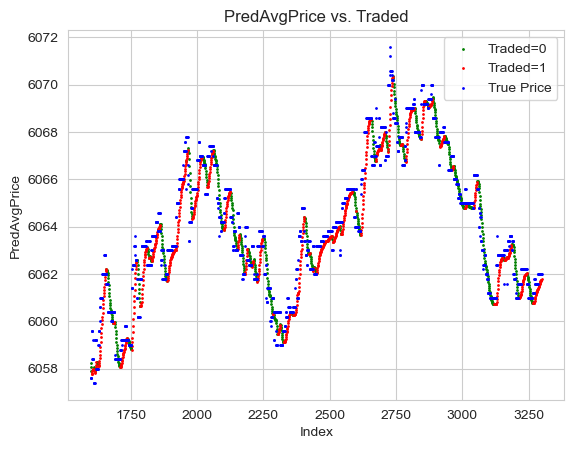

In [48]:
import matplotlib.pyplot as plt

# Assume you have the test_data DataFrame with PredAvgPrice, Traded, and the true data

# Define the range of data to be plotted
plot_df = data_traded[1000:3000][sequence_length:]

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the green points for Traded=0
ax.scatter(plot_df.index[plot_df['Traded'] == 0], plot_df['PredAvgPrice'][plot_df['Traded'] == 0], color='green', label='Traded=0', s=1)

# Plot the red points for Traded=1
ax.scatter(plot_df.index[plot_df['Traded'] == 1], plot_df['PredAvgPrice'][plot_df['Traded'] == 1], color='red', label='Traded=1', s=1)

# Plot the true data in blue
# ax.scatter(plot_df.index, plot_df['LastPrice'], color='blue', label='True Price', s=1)

# Set the title and axis labels
ax.set_title('PredAvgPrice vs. Traded')
ax.set_xlabel('Index')
ax.set_ylabel('PredAvgPrice')

# Add the legend
ax.legend()

# Display the plot
plt.show()

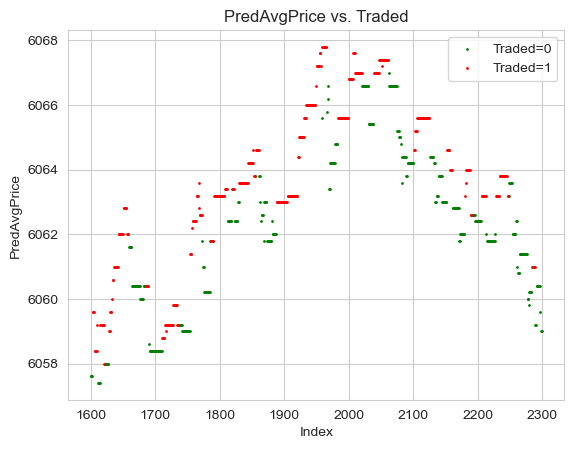

In [58]:
import matplotlib.pyplot as plt

# Assume you have the test_data DataFrame with PredAvgPrice, Traded, and the true data

# Define the range of data to be plotted
plot_df = data_traded[1000:2000][sequence_length:]

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the true data in blue
# ax.plot(plot_df.index, plot_df['LastPrice'], color='blue', label='True Price')

# Plot the green points for Traded=0
ax.scatter(plot_df.index[plot_df['Traded'] == 0], plot_df['LastPrice'][plot_df['Traded'] == 0], color='green', label='Traded=0', s=1)

# Plot the red points for Traded=1
ax.scatter(plot_df.index[plot_df['Traded'] == 1], plot_df['LastPrice'][plot_df['Traded'] == 1], color='red', label='Traded=1', s=1)

# ax.scatter(plot_df.index, plot_df['LastPrice'], color='blue', label='True Price', s=1)
# Set the title and axis labels
ax.set_title('PredAvgPrice vs. Traded')
ax.set_xlabel('Index')
ax.set_ylabel('PredAvgPrice')

# Add the legend
ax.legend()

# Display the plot
plt.show()

In [87]:
import pandas as pd
import math

# 初始化变量
capital = 100000  # 初始本金
position = 0  # 当前持仓量
last_price = 0  # 上一个时段的价格
profit = 0  # 当前累计利润
tax_rate = 0.0001  # 税率
times_trade = 0
chance = ""
bid = 0
ask = 0

# 遍历数据集，按照策略进行交易
for index, row in data_traded.iterrows():
    print("capital:", capital, "position:", position, "last_price:", last_price)
    traded = row['Traded']
    current_price = row['LastPrice']

    # 计算当前回报率
    if last_price != 0:
        return_rate = (current_price - last_price) / last_price
    else:
        return_rate = 0

    # 如果当前Traded为1且没有持仓，并且回报率大于税率，则全仓买入
    if traded == 1 and position == 0 and return_rate > tax_rate:
        times_trade = times_trade + 1
        buy_amount = math.floor(capital / current_price)
        position += buy_amount
        capital -= buy_amount * current_price
        chance = chance + (str(index)+":Bid = "+str(current_price)+"*"+str(position)+"  ")
        bid = current_price*position

    # 如果距离上一次交易已经过去了10秒，并且有持仓，则检查当前Traded和回报率
    if index > 0 and index % 10 == 0 and position > 0:
        if traded != 1 or return_rate <= tax_rate:
            capital += position * current_price
            ask = current_price*position
            position = 0
            chance = chance + (str(index)+":Ask = "+str(current_price)+"\n")
            # chance = chance + (str(index)+":Ask = "+str(last_price)+" Profit:"+str((ask-bid)*(1-tax_rate))+"\n")

    last_price = current_price

# 如果最后还有持仓，则全部卖出
if position > 0:
    capital += position * last_price
    position = 0

print("Times of Trading:",times_trade)

# 计算最终利润
profit = capital - 100000
print("Final Profit:", profit)

# 计算收益率百分百
return_rate = profit / 100000 * 100
print("Return Rate:", return_rate, "%")

capital: 100000 position: 0 last_price: 0
capital: 100000 position: 0 last_price: 6076.8
capital: 100000 position: 0 last_price: 6076.8
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6077.2
capital: 100000 position: 0 last_price: 6075.2
capital: 100000 position: 0 last_price: 6075.0
capital: 100000 position: 0 last_price: 6075.0
capital: 100000 position: 0 last_price: 6075.0
capital: 100000 position: 0 last_price: 6075.0
capital: 100000 position: 0 last_price: 6075.0
capital: 100000 position: 0 last_price: 6075.0
capital: 100000 po

In [88]:
print(chance)

328:Bid = 6077.0*16  330:Ask = 6077.0
354:Bid = 6080.6*16  360:Ask = 6081.0
384:Bid = 6081.2*16  390:Ask = 6081.6
396:Bid = 6081.6*16  400:Ask = 6081.6
424:Bid = 6081.6*16  430:Ask = 6081.0
442:Bid = 6081.2*16  450:Ask = 6081.2
458:Bid = 6082.0*16  460:Ask = 6082.2
478:Bid = 6082.8*16  480:Ask = 6082.8
489:Bid = 6082.8*16  490:Ask = 6083.0
499:Bid = 6083.8*16  500:Ask = 6082.4
568:Bid = 6078.8*16  570:Ask = 6079.8
581:Bid = 6080.4*16  600:Ask = 6080.4
629:Bid = 6079.2*16  630:Ask = 6079.2
705:Bid = 6077.2*16  710:Ask = 6078.6
729:Bid = 6081.0*16  730:Ask = 6081.0
797:Bid = 6078.6*16  800:Ask = 6078.6
833:Bid = 6076.4*16  840:Ask = 6076.6
842:Bid = 6077.8*16  850:Ask = 6078.0
960:Bid = 6071.2*16  970:Ask = 6070.2
971:Bid = 6071.2*16  980:Ask = 6070.0
1004:Bid = 6069.4*16  1010:Ask = 6070.8
1014:Bid = 6071.0*16  1020:Ask = 6069.0
1034:Bid = 6072.2*16  1040:Ask = 6071.0
1090:Bid = 6067.2*16  1100:Ask = 6067.6
1101:Bid = 6069.4*16  1110:Ask = 6067.8
1116:Bid = 6069.0*16  1120:Ask = 6068.2


In [89]:
# save data_traded
data_traded.to_csv('data_traded_lstm.csv')